В данной работе перед вами стоит задача научиться по фотографии лица человека предсказывать его пол, расу и возраст.

[Датасет](https://susanqq.github.io/UTKFace/), который мы будем использовать состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет! В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. Классификация с настолько сильной внутриклассовой изменьчивостью (от младенцев до пожилых людей!) -- очень сложная задача. 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)

Мы немного упростим себе задачу и воспользуемся версией датасета, где все картинки приведены к одному размеру и лица находятся в центре изображения.

Как решать такую задачу? Мы предлагаем вам воспользоваться **transfer learning и finetuning**. Т.е. взять за основу сеть, обученную на большом количестве данных для другой задачи и дообучить ее для нашей задачи.

# Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface . Обратите внимание на следующую информацию: Library Versions
Keras v2.2.4
Tensorflow v1.14.0. Именно эти версии библиотек нам необходимо установить.

Т.к. мы решили воспользоваться чужой моделью, нам нужно сначала понять как с ней взаимодействовать. Для этого авторы часто прикладывают пример использования своих моделей. Его можно найти в README у автора репозитория.

In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-2hdfnybn
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-2hdfnybn
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=d8691f2adf8ee449c39405dbbfbd449b49d6e5bc8785edbfaf2f3396b375ae54
  Stored in directory: /tmp/pip-ephem-wheel-cache-x4p5xhee/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [2]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install gdown

     |████████████████████████████████| 109.2MB 84kB/s 
     |████████████████████████████████| 3.2MB 20.7MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 491kB 44.8MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 317kB 4.2MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras_vggface.vggface import VGGFace
import gdown

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
import tensorflow as tf
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras.callbacks import ModelCheckpoint
from keras import Sequential
from keras.models import load_model

tf.disable_eager_execution()

In [5]:
from tensorflow.keras.utils import plot_model

In [6]:
vggface_model = VGGFace(model = 'resnet50')









165445632/165439116 [==============================] - 12s 0us/step


Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем мы заморозим большую часть этой сети и будем работать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

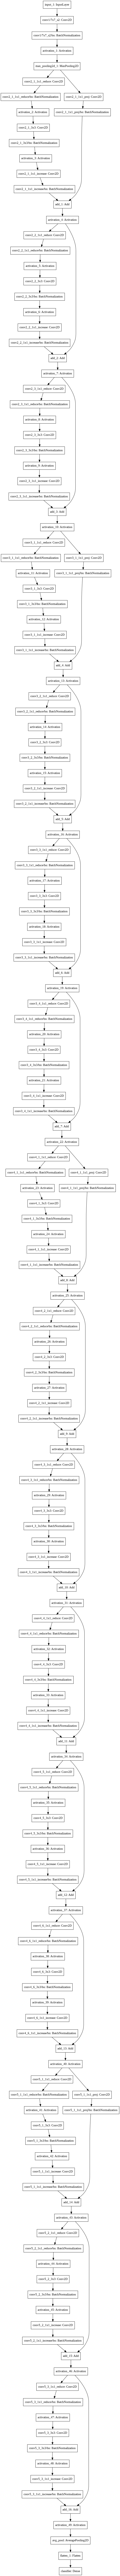

In [7]:
plot_model(vggface_model)

In [8]:
!wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2020-11-20 09:47:35--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 172.67.74.175, 104.26.7.169, 104.26.6.169, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|172.67.74.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0.01s   

2020-11-20 09:47:36 (3.14 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



In [9]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

1351680/1346516 [==============================] - 1s 1us/step


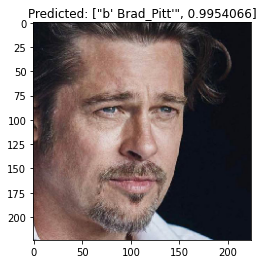

In [10]:
img = image.load_img("brad_pitt.jpg", target_size=(224, 224))     # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2)                          # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x)                                  # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}")  # используем  decode_predictions из keras_vggface
plt.imshow(img)

In [11]:
vggface_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

## Загрузка данных
Мы убедились, что модель загружена правильно, узнали какой препроцессинг ей необходим (utils.preprocess_input(x, version=2)) и теперь можем перейти к загрузке наших данных.

In [12]:
from pathlib import Path
from collections import Counter

In [13]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:02, 44.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 61.2MB/s]


'train_val_split_utk.csv'

In [14]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['4_1_2_20161219141829689.jpg.chip.jpg', '28_1_0_20170117021234085.jpg.chip.jpg', '24_1_0_20170117150815148.jpg.chip.jpg']


In [15]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg


,img_name,age,race,gender
0,40_0_0_20170117133829948.jpg.chip.jpg,0.344828,0,0
1,35_1_1_20170112215253641.jpg.chip.jpg,0.301724,1,1
2,30_0_0_20170117181235740.jpg.chip.jpg,0.258621,0,0
3,40_1_0_20170117001103881.jpg.chip.jpg,0.344828,0,1
4,68_0_1_20170117194555228.jpg.chip.jpg,0.586207,1,0


In [16]:
df.shape

(23705, 4)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
df_train, df_val, y_train, y_val = train_test_split(df, df.gender, test_size = 0.98, stratify = df.gender)
df_train.shape

(474, 4)

In [19]:
df_train1, df_val, y_train1, y_test = train_test_split(df_val, y_val, test_size = 0.02, stratify = y_val)
df_val.shape

(465, 4)

In [20]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

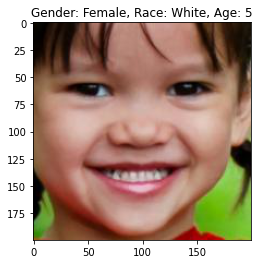

In [23]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


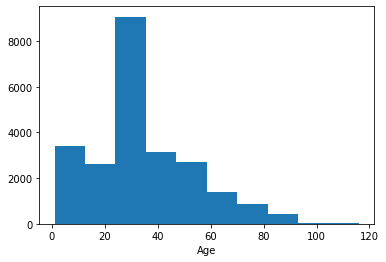

In [25]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Создание генератора данных для модели предсказания пола.
Предподготовка закончена. Мы начнем с создания модели предсказания пола. В этой части необходимо реализовать генератор данных для последущего обучения модели.

###a) 
**Создайте генератор image_gen типа ImageDataGenerator с корректным препроцессингом, соответствующем keras_vggface.** Аугментацию использовать не нужно. 

Какой препроцессинг корректный? Как мы знаем, перед применением обученных сетей нужно знать какой препроцессинг они проводят с данными. Т.к. эта модель не часть Keras, мы должны ответить на этот вопрос сами с помощью исходников автора этой сети. К счастью, он приводит пример использования на главной странице репозитория. Видно, что он использует функцию preprocess_input из utils. Значит ей мы и должны воспользоваться!

In [26]:
from keras.preprocessing.image import ImageDataGenerator

In [27]:
def preprocess_input_facenet(image):
    preprocessed = utils.preprocess_input(image, version = 2)
    return preprocessed

image_gen = ImageDataGenerator(preprocessing_function = preprocess_input_facenet)

###b)

Для генерации картинок часто используют `image_gen.flow_from_folder`. Но для этого данные должны быть расположены на диске с определенной структурой папок, что в данном случае не очень удобно. Поэтому мы воспользуемся более гибким `image_gen.flow_from_dataframe`, который позволяет генерировать данные с нужными классами используя датафрейм (мы его создали выше для вас).

**Ознакомьтесь с документацией по [ссылке](https://keras.io/preprocessing/image/) (раздел flow_from_dataframe) и создайте train_generator и val_generator для df_train и df_val соответственно.**
*  Генератор должен возвращать картинку и ее класс (male/female)
*  class_mode укажите "binary", directory=str(data_folder)
*  batch_size, image_size указаны ниже
*  train_generator должен перемешивать данные, а val_generator -- не должен

In [28]:
BATCH_SIZE = 64
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(dataframe = df_train, directory=str(data_folder), x_col="img_name", y_col="gender", subset="training",
                                              batch_size=BATCH_SIZE, shuffle=True, class_mode="binary", target_size=(IMAGE_SIZE,IMAGE_SIZE))

val_generator = image_gen.flow_from_dataframe(dataframe = df_val, directory=str(data_folder), x_col="img_name", y_col="gender",
                                              batch_size=BATCH_SIZE, shuffle=False, class_mode="binary", target_size=(IMAGE_SIZE,IMAGE_SIZE))

Found 474 validated image filenames belonging to 2 classes.
Found 465 validated image filenames belonging to 2 classes.


In [29]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


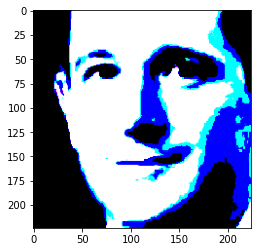

In [30]:
plt.imshow(sample_images[50])
print(gender_mapping[int(sample_labels[50])])
# мы получим очень странное изображение и это нормально. 
# matplotlib ожидает картинку с интесивностями от 0 до 1 если она типа float и от 0 до 255 если int.

In [31]:
print(sample_images[50].max(), sample_images[50].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

123.9088 -123.0912


###с)
**Реализуем функцию `deprocess_image`, которая преобразует картинку исользуемую keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.**
*  вам понадобится https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py
*  необходимо проделать операции preprocess_input в обратном порядке
*  наш случай: version=2, format="channels_last"

Male


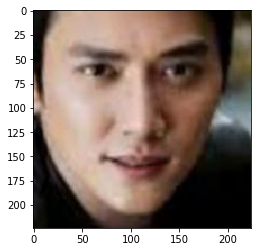

In [32]:
#image -- тензор размера (1, H, W, 3)

def deprocess_image(vggface_image):
    x_temp = np.copy(vggface_image)
    x_temp[..., 0] += 91.4953
    x_temp[..., 1] += 103.8827
    x_temp[..., 2] += 131.0912
    x_temp = x_temp[..., ::-1]
    x_temp = np.uint8(x_temp)
    return x_temp

# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])])

## Обучение модели предсказания пола

Теперь можно приступить к обучению модели предсказания пола. 

*   Возьмите за основу 'base_model' (определена ниже)
*   Вы должны сами решить сколько слоев замораживать и сколько полносвзяных слоев использовать. Рекомендуем начинать с модели с меньшим числом обучаемых параметров.
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_gender/checkpoint_best.h5"



In [ ]:
vggface_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [33]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

last_layer = vggface_model.get_layer('avg_pool').output
base_model = Model(vggface_model.input, last_layer)
base_model.trainable = False
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

Добавляем свои слои.

In [34]:
model = Sequential([base_model,
                    Flatten(),
                    #Dropout(0.5),
                    #Dense(4, activation = 'relu'),
                    #Dropout(0.5),
                    Dense(2, activation = 'softmax')])

Монтируем гугл-диск для сохранения checkpoint лучшей модели.

In [35]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [37]:
# Путь до вашего гугл диска скорее всего выглядит так: /content/drive/My Drive/
# если эта клетка вызывает ошибку, 
# измените путь согласно ! ls "/content/drive/"
path = Path("/content/drive/My Drive/UTKFace/model_gender")
path.mkdir(exist_ok=True, parents=True) # папка создается на вашем гугл диске. вместе с "родителями"
assert path.exists()
cpt_filename = "checkpoint_best_model_gender.h5"  
cpt_path =str(path / cpt_filename)
# После выполнения этой клетки, в вашем гугл диске должна создаться папка: UTKFace/model_1
# убедитесь в этом

In [38]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

cp_callback = ModelCheckpoint(filepath = cpt_path, save_weights_only = False, verbose = 1, save_best_only = True)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


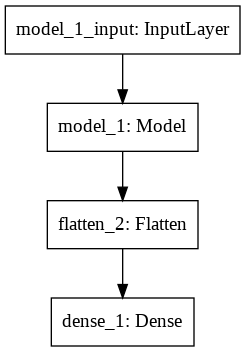

In [ ]:
plot_model(model)

In [41]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

In [ ]:
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = val_generator,
                              validation_steps = STEP_SIZE_VALID,
                              callbacks = [cp_callback],
                              verbose = 1,
                              epochs = 500)

Epoch 1/5
7/7 [==============================] - 206s 29s/step - loss: 0.5702 - acc: 0.7554 - val_loss: 0.6832 - val_acc: 0.7781

Epoch 00001: val_loss improved from inf to 0.68320, saving model to /content/drive/My Drive/UTKFace/model_gender/checkpoint_best_model_gender.h5
Epoch 2/5
7/7 [==============================] - 203s 29s/step - loss: 0.2723 - acc: 0.8769 - val_loss: 0.5292 - val_acc: 0.8204

Epoch 00002: val_loss improved from 0.68320 to 0.52916, saving model to /content/drive/My Drive/UTKFace/model_gender/checkpoint_best_model_gender.h5
Epoch 3/5
7/7 [==============================] - 213s 30s/step - loss: 0.2062 - acc: 0.9241 - val_loss: 0.5361 - val_acc: 0.8504

Epoch 00003: val_loss did not improve from 0.52916
Epoch 4/5
7/7 [==============================] - 204s 29s/step - loss: 0.2116 - acc: 0.9366 - val_loss: 0.4405 - val_acc: 0.8454

Epoch 00004: val_loss improved from 0.52916 to 0.44048, saving model to /content/drive/My Drive/UTKFace/model_gender/checkpoint_best_mo

In [ ]:
def show_progress(history: dict):
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)    
    plt.plot(history["acc"],label='train accuracy')
    plt.plot(history["val_acc"], label='test accuracy')
    ax2 = plt.subplot(1,2,2)
    plt.plot(history["loss"],label='train_loss')
    plt.plot(history["val_loss"],label='test_loss')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()

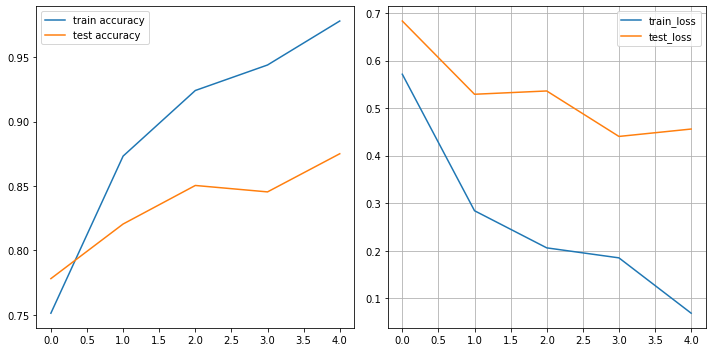

In [ ]:
show_progress(history.history)

In [42]:
loss, acc = model.evaluate_generator(val_generator, steps = STEP_SIZE_VALID)
acc

0.8453865341117555

In [39]:
model = load_model(cpt_path)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
loss, acc = model.evaluate_generator(val_generator, steps = STEP_SIZE_VALID)
if acc < 0.9:
    print(acc, "Please, try harder!")
else:
    if acc >= 0.94:
        print(acc, "Well done!")
    else:
        print(acc, "Very good! Can you improve accuracy?")

0.8478802996977903 Please, try harder!


(вспомогательный код, выполните клетку)

In [43]:
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

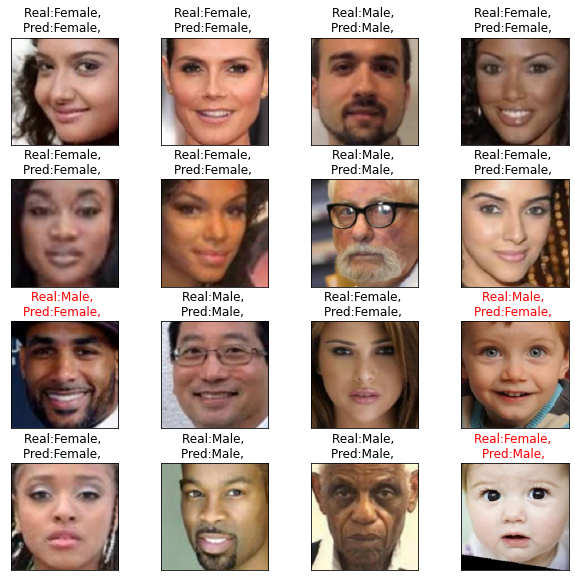

In [48]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model.predict(sample_validation_images)
predicted = predicted.argmax(axis=-1)
show_faces(sample_validation_images, real_gender = sample_validation_labels, predicted_gender=predicted)